In [3]:
import numpy as np 
import matplotlib.pyplot as plt 

x = [19, 20, 21, 22, 22, 23, 24, 25, 26, 27, 29, 30, 35, 40, 50, 60, 63, 64, 68]
y = [510, 580, 560, 480, 500, 490, 570, 520, 480, 410, 430, 420, 390, 450, 380, 330, 410, 420, 430]
x = np.asarray(x, dtype=float)
y = np.asarray(y, dtype=float)
n = len(y)

rng = np.random.default_rng(42)

In [4]:
def simulate_y(x, a, b, sigma, rng):
    # Example simulator: linear mean + Gaussian noise
    return a + b * x + rng.normal(0.0, sigma, size=len(x))

In [5]:
# -----------------------
# Summary statistics (choose ones that capture what matters)
# -----------------------
def ols_slope_intercept(x, y):
    xbar, ybar = x.mean(), y.mean()
    b = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar)**2)
    a = ybar - b * xbar
    return a, b

def summary_stats(x, y):
    a_hat, b_hat = ols_slope_intercept(x, y)
    return np.array([
        y.mean(),
        y.std(ddof=1),
        a_hat,
        b_hat
    ])

s_obs = summary_stats(x, y) 
print("summary statistics: ", s_obs)

summary statistics:  [461.05263158  68.38573087 558.91370682  -2.7834737 ]


In [6]:
# Scale summaries so no single stat dominates distance
# (Very important in ABC)
scale = np.array([
    max(y.std(ddof=1), 1e-6),
    max(y.std(ddof=1), 1e-6),
    max(abs(s_obs[2]), 1.0),
    max(abs(s_obs[3]), 1.0)
])
print("scale: ", scale)

scale:  [ 68.38573087  68.38573087 558.91370682   2.7834737 ]


In [7]:
def discrepancy(s_sim, s_obs, scale):
    z = (s_sim - s_obs) / scale
    return np.sqrt(np.sum(z**2))

In [8]:
# -----------------------
# Priors (examples)
# -----------------------
def sample_prior(rng):
    # Intercept a: around distance range
    a = rng.uniform(y.min() - 50, y.max() + 50)

    # Slope b: often negative (distance decreases with age).
    # If you want to allow both signs, change to rng.uniform(-10, 10).
    b = rng.uniform(-10.0, 0.0)

    # Noise sigma > 0
    sigma = rng.uniform(1.0, max(5.0, y.std(ddof=1) * 2))
    return a, b, sigma


In [9]:
def abc_pilot_epsilon(x, y, s_obs, scale, n_pilot=5000, quantile=0.02, rng=None):
    rng = rng
    dists = np.empty(n_pilot)

    for i in range(n_pilot):
        a, b, sigma = sample_prior(rng)
        y_sim = simulate_y(x, a, b, sigma, rng)
        s_sim = summary_stats(x, y_sim)
        dists[i] = discrepancy(s_sim, s_obs, scale)

    eps = np.quantile(dists, quantile)
    return eps, dists

eps, pilot_dists = abc_pilot_epsilon(x, y, s_obs, scale, n_pilot=8000, quantile=0.02, rng=rng)
print("Chosen epsilon =", eps)


Chosen epsilon = 0.5391232234831813


In [10]:
def abc_rejection(x, y, s_obs, scale, eps, n_accept=2000, max_trials=2_000_000, rng=None):
    rng = rng
    accepted = []
    dists_acc = []

    trials = 0
    while len(accepted) < n_accept and trials < max_trials:
        trials += 1
        a, b, sigma = sample_prior(rng)
        y_sim = simulate_y(x, a, b, sigma, rng)
        s_sim = summary_stats(x, y_sim)
        d = discrepancy(s_sim, s_obs, scale)

        if d <= eps:
            accepted.append((a, b, sigma))
            dists_acc.append(d)

    acc = np.array(accepted)
    dists_acc = np.array(dists_acc)
    return acc, dists_acc, trials

post, dacc, trials = abc_rejection(x, y, s_obs, scale, eps, n_accept=1500, rng=rng)
print("Accepted:", len(post), "Trials:", trials, "Acceptance rate:", len(post)/trials)

a_samps, b_samps, sigma_samps = post[:,0], post[:,1], post[:,2]
print("Posterior mean b:", b_samps.mean(), "  P(b<0):", np.mean(b_samps < 0))


Accepted: 1500 Trials: 62842 Acceptance rate: 0.023869386715890645
Posterior mean b: -2.784544124269703   P(b<0): 1.0


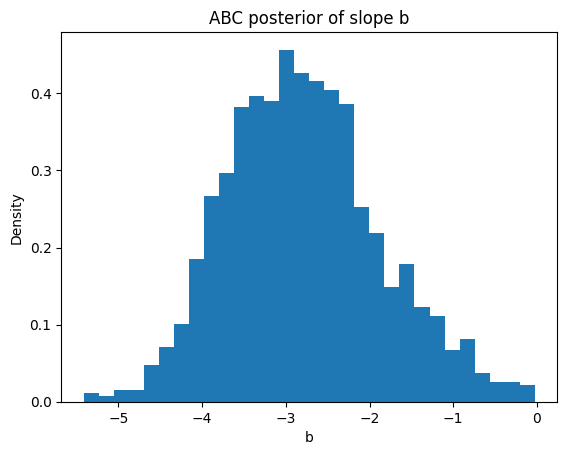

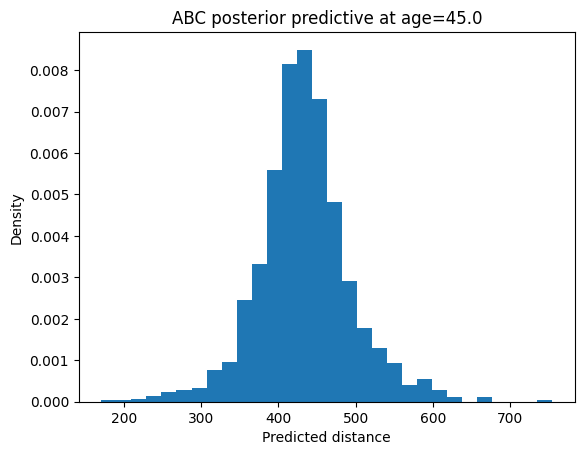

Predictive mean: 433.3189510926846
95% predictive interval: [316.40226075 567.96731968]


In [11]:
plt.hist(b_samps, bins=30, density=True)
plt.title("ABC posterior of slope b")
plt.xlabel("b")
plt.ylabel("Density")
plt.show()

new_age = 45.0
y_new = a_samps + b_samps * new_age + rng.normal(0, sigma_samps, size=len(sigma_samps))

plt.hist(y_new, bins=30, density=True)
plt.title(f"ABC posterior predictive at age={new_age}")
plt.xlabel("Predicted distance")
plt.ylabel("Density")
plt.show()

print("Predictive mean:", y_new.mean())
print("95% predictive interval:", np.quantile(y_new, [0.025, 0.975]))


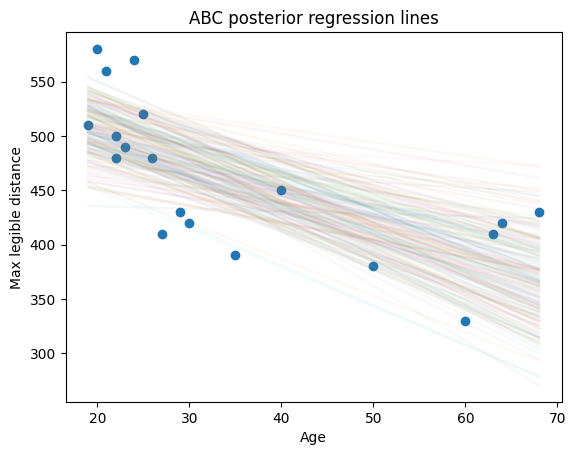

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# post is (N, 3): columns [a, b, sigma]
a_samps = post[:, 0]
b_samps = post[:, 1]

x = np.asarray(x, dtype=float)
y = np.asarray(y, dtype=float)

x_grid = np.linspace(x.min(), x.max(), 200)

# choose up to 200 posterior draws to plot
idx = np.random.choice(len(a_samps), size=min(200, len(a_samps)), replace=False)

plt.scatter(x, y, label="Observed data")

for i in idx:
    plt.plot(x_grid, a_samps[i] + b_samps[i] * x_grid, alpha=0.05)

plt.xlabel("Age")
plt.ylabel("Max legible distance")
plt.title("ABC posterior regression lines")
plt.show()
